# Training a Binary model to solve a convex optimization problem

In this notebook we consider the following optimization problem :

$$ \mathcal{L}(\theta) = \frac{1}{2}(\theta - \theta^{*})^{T}H (\theta - \theta^{*})$$

$$ -\frac{\partial \mathcal{L}}{\partial \theta} = - H (\theta - \theta^{*})$$

$$ \theta_{t+1} = \theta_{t} - \eta H (sign_{\mathcal{CB}}(\theta_{t}) - \theta^{*}) $$

With $H$ a positive symmetric definite matrix.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib import rc, rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML

rcParams['axes.linewidth'] = 4
rcParams['xtick.labelsize'] = 40
rcParams['ytick.labelsize'] = 40
rcParams['axes.titlesize'] = 40
rcParams['axes.labelsize'] = 35
rcParams['lines.markersize'] = 2
rcParams.update({'figure.autolayout': True})
rc('text', usetex=True)                         # r"$...$" for latex string

In [19]:
# Functions needed for the toy problem

def cost(H, theta, theta_star):
    """
    cost computes the loss associated with the parameter theta in a landscape defined by H and theta_star
    H : PSD matrix of dimensions d x d
    theta : parameter column vector (d, 1)
    theta_star : global optimum vector (d, 1)
    """
    assert(H.size(0)==H.size(1))
    assert(H.size(0)==theta.size(0))
    assert(theta.size()==theta_star.size())
    
    diff = theta-theta_star
    return 0.5*torch.mm(diff.t(), torch.mm(H,diff)).sum().item()

def cost_map(H, x, y, theta_star):
    """
    cost_map returns the square numpy array containing cost values to generate the colormap
    it computes the cost of each 2D parameter made of first component in x and second component in y
    """
    assert(H.size(0)==H.size(1))
    assert(H.size(0)==theta_star.size(0))
    assert(theta_star.size(0)==2)
    
    size = x.shape[0]
    theta_x = torch.tensor(x, dtype=torch.float32).view(1,-1)
    theta_y = torch.tensor(y, dtype=torch.float32).view(1,-1)
    theta = torch.cat([theta_x, theta_y], dim =0).view(2,-1)
    diff = theta-theta_star
    return 0.5*torch.mm(diff.t(), torch.mm(H,diff)).diag().view(size,size).numpy()

def gradient(H, theta, theta_star):
    """
    Computes the gradient associated with parameter theta
    """
    assert(H.size(0)==H.size(1))
    assert(H.size(0)==theta.size(0))
    assert(theta.size()==theta_star.size())    
    
    diff = theta-theta_star
    return torch.mm(H, diff)

def step_sgd(H, theta, theta_star, lr = 0.1):
    """
    Computes the hidden parameter theta after one step of gradient descent applied to the binarized parameter
    """
    assert(H.size(0)==H.size(1))
    assert(H.size(0)==theta.size(0))
    assert(theta.size()==theta_star.size())    
    
    bin_theta = theta.sign()   # Binarized parameter
    
    theta -= lr*gradient(H, bin_theta, theta_star)
    return theta
 
def coor(theta):
    """
    returns the tuple of coordinates for 2D use
    """
    assert(theta.size()==torch.empty(2,1).size())
    theta = theta.view(2,1)
    return theta[0,0].item(), theta[1,0].item()

def H_product_BC(H, x, y):
    """
    Computes the scalar product defined by PSD matrix H
    """
    assert(H.t()==H)
    assert(H.size(0)==x.size(0))
    assert(x.size()==y.size())
    
    return torch.mm(x.t(), torch.mm(H,y)).item()

In [20]:
# Case where H eigen axis are random
dim = 2
num_epochs = 500
torch.manual_seed(11)

init_coor = [0.01, 0.02]
theta = torch.tensor(init_coor, dtype=torch.float32).view(2,1)
theta_initial = torch.tensor(init_coor, dtype=torch.float32).view(2,1)
theta_star = torch.tensor([1.5, 0.5], dtype=torch.float32).view(2,1)

print('\ntheta_star =', theta_star.t())
print('\ntheta_initial =', theta_initial.t())

D = torch.diag(5*torch.rand(dim))
u = torch.randn((dim,1))
t = 2/torch.mm(u.t(), u).item()
A = torch.eye(dim)-t*torch.mm(u,u.t())
H = torch.mm(A,torch.mm(D,A))

print('\nH =', H)
eig_val, eig_vec = torch.symeig(H, eigenvectors=True)
print('\neig_val =', eig_val)
print('\neig_vec =', eig_vec)


theta_star = tensor([[1.5000, 0.5000]])

theta_initial = tensor([[0.0100, 0.0200]])

H = tensor([[2.4047, 0.2158],
        [0.2158, 0.7733]])

eig_val = tensor([0.7452, 2.4328])

eig_vec = tensor([[ 0.1290, -0.9916],
        [-0.9916, -0.1290]])


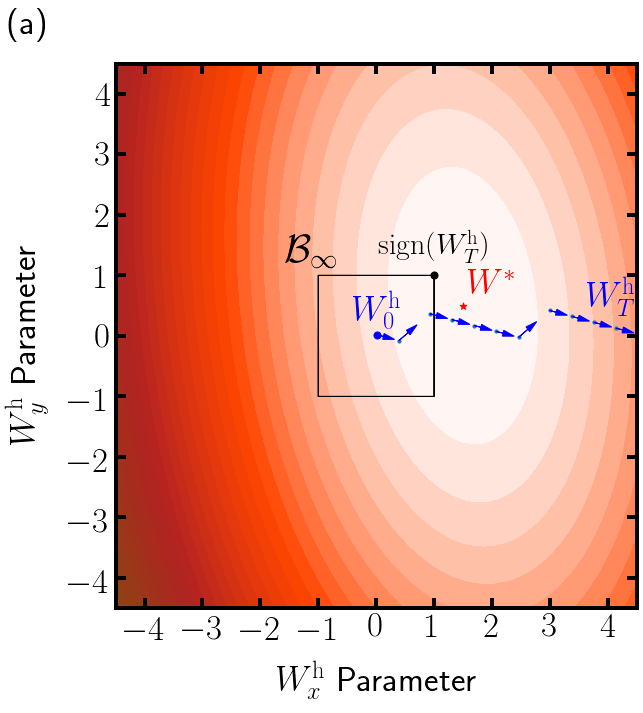

In [21]:
traj_x = []
traj_y = []

cube_x = [1.0,1.0,-1.0,-1.0]
cube_y = [1.0,-1.0,-1.0,1.0]


for t in range(num_epochs):
    theta = step_sgd(H, theta, theta_star, lr=0.35)   
    traj_x.append(theta[0,0].item())
    traj_y.append(theta[1,0].item())



    
plt.figure(figsize=(9,10))


ts_x, ts_y = coor(theta_star)
ti_x, ti_y = coor(theta_initial)
tb_x, tb_y = coor(theta.sign())


zoom = 4.5


# Colormap of the landscape
x , y = np.meshgrid(np.linspace(-zoom,zoom,100),np.linspace(-zoom,zoom,100))
z = cost_map(H, x, y, theta_star)
cmap0 = LinearSegmentedColormap.from_list('cmap0', ['white', 'orangered','firebrick', 'saddlebrown'])
landscape = plt.contourf(x, y, z, 30, cmap=cmap0, colors=None)

# Relevant points
plt.scatter(traj_x, traj_y, s=10.0, label='traj', alpha=1.0)                 # Trajectory of hidden weights
plt.scatter(ts_x, ts_y, s=50.0, marker='*', color ='r')                      # Global optimum
plt.scatter(ti_x, ti_y, s=50.0, color='b')                                   # Initial values of the hidden weights
plt.scatter(np.sign(traj_x[9]), np.sign(traj_y[9]), s=50.0, color='black')   # Binary weights

# Arrows for hidden weights trajectory
for idx in range(4):
    plt.arrow(cube_x[idx], cube_y[idx], cube_x[idx-1]-cube_x[idx], cube_y[idx-1]-cube_y[idx], linewidth=1)

# Lines for the inifinite norm unit ball 
plt.arrow(ti_x, ti_y, 0.3*(traj_x[0]-ti_x), 0.3*(traj_y[0]-ti_y), color='b', head_length=.2, head_width=.1)
for t in range(len(traj_x)-1):
    plt.arrow(traj_x[t], traj_y[t], 0.3*(traj_x[t+1]-traj_x[t]), 0.3*(traj_y[t+1]-traj_y[t]), color='b', head_length=.2, head_width=.1)
    

    
# Text, may have to be tuned for other settings
plt.text(ts_x+0.5, ts_y+0.2, r'$W^{*}$', horizontalalignment='center', fontsize=35, color='r')
plt.text(ti_x, ti_y+0.1, r'$W_{0}^{{\rm h}}$', horizontalalignment='center', fontsize=35, color='b')
plt.text(traj_x[9]-0.1, traj_y[9]+0.2, r'$W_{T}^{{\rm h}}$', horizontalalignment='center', fontsize=35, color='b')
plt.text(np.sign(traj_x[9]), np.sign(traj_y[9])+0.2, r'${\rm sign}(W_{T}^{{\rm h}})$', horizontalalignment='center', fontsize=30)
plt.text(-1.1, 1.1, r'$\mathcal{B}_{\infty}$', horizontalalignment='center', fontsize=40)
plt.text(-zoom-1.5, 0.5+zoom, r'(a)', horizontalalignment='center', fontsize=35)
plt.text(0.0, -1.5-zoom, r'$W^{{\rm h}}_{x}$ Parameter', horizontalalignment='center', fontsize=35)
plt.text(-1.5-zoom, -1.7, r'$W^{{\rm h}}_{y}$ Parameter', horizontalalignment='center', fontsize=35, rotation = 90)


# Axes properties
axes = plt.gca()
label_pad = 5

axes.set_xlim(-zoom, zoom)
axes.xaxis.set_ticks(range(-int(zoom),int(zoom+1)))
axes.xaxis.set_tick_params(direction = 'in', labelsize = 35, length = 10, width = 4, top = True, bottom = True, pad = label_pad, which = 'major')
axes.xaxis.set_tick_params(direction = 'in', labelsize = 35, length = 6, width = 3, top = True, bottom = True, pad = label_pad, which = 'minor')

axes.set_ylim(-zoom, zoom)
axes.yaxis.set_ticks(range(-int(zoom),int(zoom+1)))
axes.yaxis.set_tick_params(direction = 'in', labelsize = 35, length = 10, width = 4, right = True, left = True, pad = label_pad, which='major')
axes.yaxis.set_tick_params(direction = 'in', labelsize = 35, length = 6, width = 3, right = True, left = True, pad = label_pad, which='minor')

#plt.savefig('traj_2D.png', format='png', dpi =300)
plt.show()

n= 3   -->   det(R) = 1.0
n= 4   -->   det(R) = -1.0
n= 5   -->   det(R) = 1.0
n= 6   -->   det(R) = -0.9999997019767761
n= 7   -->   det(R) = 0.9999997019767761
n= 8   -->   det(R) = -1.0000001192092896
n= 9   -->   det(R) = 1.0
n= 10   -->   det(R) = -1.0000003576278687
n= 11   -->   det(R) = 1.0000004768371582
n= 12   -->   det(R) = -1.0000004768371582
n= 13   -->   det(R) = 1.000000238418579
n= 14   -->   det(R) = -1.000000238418579
n= 15   -->   det(R) = 1.0000003576278687
n= 16   -->   det(R) = -1.0000003576278687
n= 17   -->   det(R) = 0.9999995231628418
n= 18   -->   det(R) = -0.9999996423721313
n= 19   -->   det(R) = 0.9999992847442627
n= 20   -->   det(R) = -1.0
n= 21   -->   det(R) = 1.0000001192092896
n= 22   -->   det(R) = -1.0000001192092896
n= 23   -->   det(R) = 0.9999999403953552
n= 24   -->   det(R) = -1.0000004768371582
n= 25   -->   det(R) = 1.0000003576278687
n= 26   -->   det(R) = -1.0000003576278687
n= 27   -->   det(R) = 1.0
n= 28   -->   det(R) = -1.00000035762

n= 266   -->   det(R) = -1.0000070333480835
n= 267   -->   det(R) = 1.0000077486038208
n= 268   -->   det(R) = -1.0000061988830566
n= 269   -->   det(R) = 1.0000050067901611
n= 270   -->   det(R) = -1.000005841255188
n= 271   -->   det(R) = 1.000004768371582
n= 272   -->   det(R) = -1.0000059604644775
n= 273   -->   det(R) = 1.0000053644180298
n= 274   -->   det(R) = -1.0000040531158447
n= 275   -->   det(R) = 1.0000050067901611
n= 276   -->   det(R) = -1.0000054836273193
n= 277   -->   det(R) = 1.0000051259994507
n= 278   -->   det(R) = -1.0000029802322388
n= 279   -->   det(R) = 1.0000039339065552
n= 280   -->   det(R) = -1.000003457069397
n= 281   -->   det(R) = 1.0000041723251343
n= 282   -->   det(R) = -1.0000050067901611
n= 283   -->   det(R) = 1.0000038146972656
n= 284   -->   det(R) = -1.0000019073486328
n= 285   -->   det(R) = 1.0000061988830566
n= 286   -->   det(R) = -1.000005841255188
n= 287   -->   det(R) = 1.0000033378601074
n= 288   -->   det(R) = -1.000005841255188
n= 2

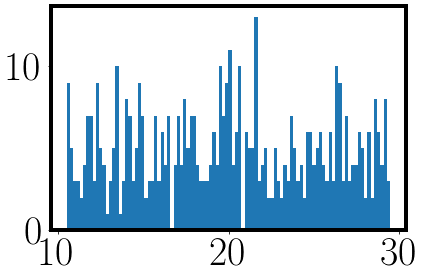

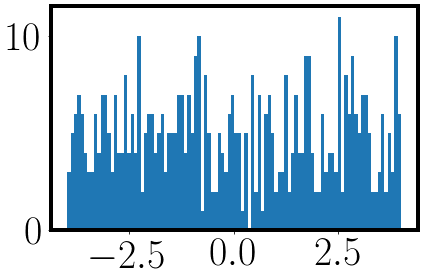

In [22]:
dim = 500
num_epochs = 1000
lrate = 0.01

mu = 20
sigma = 19

mu_star = 0.0
sigma_star = 4.0


torch.manual_seed(1)

theta = 0.01*torch.randn((dim,1))
theta_star = mu_star + sigma_star*2*(torch.rand((dim,1))-0.5)
#theta = -theta.abs()*theta_star.sign()
theta_initial = torch.empty((dim,1)).copy_(theta)


# PSD matrix generation
D = torch.diag(mu*torch.ones(dim) + sigma*(torch.rand(dim)-0.5))      # eigen values

angle = 2*math.pi*torch.rand(1).item()                                # uniformly distributed angle in dim 2
cos = math.cos(angle)
sin = math.sin(angle)
b = 1 if torch.rand(1).item() > 0.5 else -1
R = torch.tensor([[cos,     sin], 
                  [-b*sin, b*cos]], dtype=torch.float32)              # uniformly distributed rotation of O(2) 

for n in range(3, dim+1):                                             # sub group algorithm Shahshahani
    print('n=', n, '  -->   det(R) =', torch.det(R).item())
    e_1 = torch.zeros((n,1), dtype=torch.float32)
    e_1[0,0] = 1
    v = torch.randn((n,1), dtype=torch.float32)
    v = v/(v.pow(2).sum().sqrt())
    c = (e_1 - v).pow(2).sum().sqrt().item()
    x = (e_1 - v)/c
    refl = torch.eye(n, dtype=torch.float32) - 2*torch.mm(x, x.t())
    A = torch.zeros((n,n), dtype=torch.float32)
    A[0,0] = 1
    A[1:,1:] = R
    R = torch.mm(refl, A)


print('det(R) =', np.linalg.det(R.numpy()))
H = torch.mm(R.t(),torch.mm(D,R))
H = (H + H.t())/2                                  # ensure symmetry despite numerical instability


print('diagonal mass =', H.abs().diag().sum().item()/H.abs().sum().item())
print('\nH =', H)
print('\ntheta_star =', theta_star.t())

eig_val, eig_vec = torch.symeig(H, eigenvectors=True, )
print('\neig_val =', eig_val)
print('\neig_vec =', eig_vec)

assert(eig_val.min().item()>0)                     # ensure Positivity

H_inv = torch.inverse(H)
H_inv_normalised = H_inv/(H_inv.pow(2).sum(dim=0).pow(0.5))
print('\northogonality of H_inv(BC) =', torch.mm(H_inv_normalised.t(), H_inv_normalised))

plt.hist(eig_val.numpy(),100)
plt.show()
plt.hist(theta_star.numpy(), 100)
plt.show()

In [23]:
#SGD dim > 2

traj = torch.empty((dim,num_epochs))
loss = []

for t in range(num_epochs):
    theta = step_sgd(H, theta, theta_star, lr=lrate)
    traj[:,t] = theta[:,0]
    loss.append(cost(H, theta.sign(), theta_star))


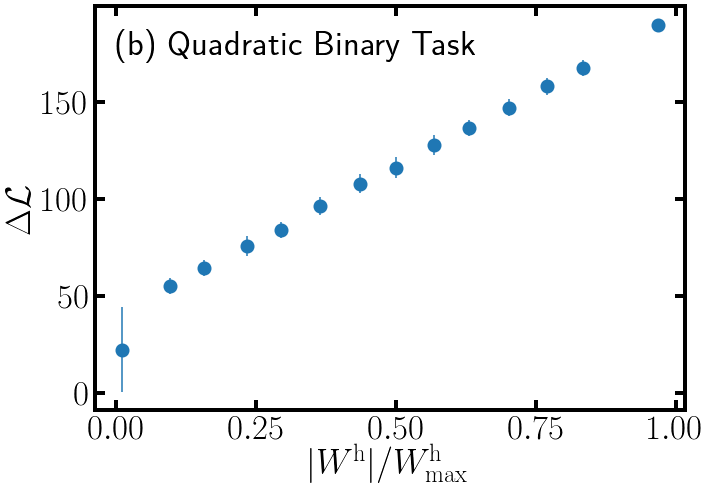

In [24]:
switch = torch.ones((dim,dim))-2*torch.eye(dim)
max_magnitude = theta.abs().max().item()
bins = 15

theta_bin = theta.sign()
final_cost = cost(H, theta_bin, theta_star)
costs = []

for d in range(dim):
    theta_switched = switch[:,d].view(dim,1)*(theta_bin)
    switched_cost = cost(H, theta_switched, theta_star)
    costs.append(switched_cost-final_cost)

costs_tensor = torch.tensor(costs, dtype=torch.float32).view(-1,1)

hidden_magnitude = []
costs_mean = []
costs_std = []

for k in range(bins):
    indices = (theta.abs() > (k/bins)*max_magnitude)*(theta.abs() < ((k+1)/bins)*max_magnitude)
    costs_mean.append(costs_tensor[indices].mean().item())
    costs_std.append(costs_tensor[indices].std().item())
    hidden_magnitude.append(theta[indices].abs().mean().item()/max_magnitude)



fig = plt.figure(figsize=(10,7))
plt.errorbar(hidden_magnitude, costs_mean, yerr=costs_std, fmt='o', ms=10, mew=4)
axes = plt.gca()
label_pad = 5

plt.text(0, 175, '(b) Quadratic Binary Task', fontsize=35)

axes.set_xlabel(r'$|W^{{\rm h}}|/W^{{\rm h}}_{{\rm max}}$', fontsize = 35)
axes.xaxis.set_ticks(list(np.linspace(0.0,1.0,5)))
axes.xaxis.set_tick_params(direction = 'in', labelsize = 35, length = 10, width = 4, top = True, bottom = True, pad = label_pad, which = 'major')
axes.xaxis.set_tick_params(direction = 'in', labelsize = 35, length = 6, width = 3, top = True, bottom = True, pad = label_pad, which = 'minor')

axes.set_ylabel(r'$\Delta \mathcal{L}$', fontsize = 35)
axes.yaxis.set_tick_params(direction = 'in', labelsize = 35, length = 10, width = 4, right = True, left = True, pad = label_pad, which='major')
axes.yaxis.set_tick_params(direction = 'in', labelsize = 35, length = 6, width = 3, right = True, left = True, pad = label_pad, which='minor')


plt.show()